In [118]:
from math import cos, sin, sqrt, atan
import numpy as np
import numpy.linalg as la
from scipy. integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [120]:
def drawSet(fig, ax, rho, N):
    L = np.array([[cos(x / N * 2 * np.pi), sin(x / N * 2 * np.pi)] for x in range(N)])
    val = np.empty(N); point = np.empty((N, 2))
    for i in range(N):
        val[i], point[i] = rho(L[i])
    ax.plot(point[:, 0], point[:, 1], c='darkmagenta')
    ax.fill(point[:, 0], point[:, 1], c='darkmagenta')

In [121]:
class LinearSolver():
    def __init__(self, params):
        for key, value in params.items():
            setattr(self, key, value)
        self.ode_max_step = 0.01
        self.t1_min = self.t1
        
        self.hull = []
        self.eps = 1e-2
        self.psi_eps = 1e-1 * 2 * np.pi
        self.psi = []
        self.psi0 = []
        self.psi_grid = []
        self.x0 = []
        self.t_event = []
        self.trajectory = []
        
    def rho_X0(self, v):
        # v = [v0, v1]
        val = v @ self.center.reshape(-1, 1) + self.r * la.norm(v)
        x_opt = self.center + v / la.norm(v) * self.r
        return (val, x_opt)
    
    def make_hull(self):
        # все точки пересечения прямых и прямых с окружностью, которые лежат в X1 
        m = self.G.shape[0]

        for i in range(m):
            for j in range(i + 1, m):
                G1 = np.array([self.G[i, :], self.G[j, :]])
                g1 = np.array([self.g[i], self.g[j]])
                if np.abs(la.det(G1)) > self.eps:
                    x = la.solve(G1, -g1)
                    if self.check(x) <= 0:
                        self.hull.append(x)
           
        for i in range(m):
            k = self.G[i][0]; m = self.G[i][1]
            x2 = -self.g[i] / m
            if k < self.eps:
                x1 = self.R ** 2 - x2 ** 2
                if x1 > self.eps:
                    x1 = sqrt(x1)
                    x = np.array([x1, x2])
                    if np.max(self.G @ x + self.g) <= 0:
                        self.hull.append(x)

                    x = np.array([-x1, x2])
                    if np.max(self.G @ x + self.g) <= 0:
                        self.hull.append(x)
            else:
                d = (m / k) ** 2 + 1
                D = (m * self.g[i] / k) ** 2 - ((self.g[i] / k) ** 2 - self.R ** 2) * d
                if D > self.eps:
                    x2 = (-m * self.g[i] / k + sqrt(D)) / d
                    x1 = (-self.g[i] - m * x2) / k
                    x = np.array([x1, x2])
                    if np.max(self.G @ x + self.g) <= 0:
                        self.hull.append(x)
                    
                    x2 = (-m * self.g[i] / k - sqrt(D)) / d
                    x = np.array([x1, x2])
                    if np.max(self.G @ x + self.g) <= 0:
                        self.hull.append(x)

#         hull_wout_dupl = []
#         for i in self.hull:
#             if i not in hull_wout_dupl: 
#                 hull_wout_dupl.append(i)
#         self.hull = hull_wout_dupl
        self.hull = np.array(self.hull)
        return
    
    def rho_X1(self, v):
        if len(self.hull) == 0:
            self.make_hull()
        x = v / la.norm(v) * self.R
        rho = self.hull @ v.reshape(-1, 1)
        if np.max(self.G @ x + self.g) <= 0:
            rho = np.vstack((rho, x @ v.reshape(-1, 1)))
        idx = np.argmax(rho)
        val = rho[idx]
        if idx < self.hull.shape[0]:
            x_opt = self.hull[idx].copy()
        else:
            x_opt = x
        return (val, x_opt)

    def rho_P(self, v):
        # v - vector
        if v[1] > 0 and abs(v[0]) / (2 * self.c * v[1]) < sqrt(self.b / (self.a + self.c)):
            val = v[1] * self.b + (v[0] ** 2) / (4 * self.c * v[1])
            x_opt = [v[0] / (2 * self.c * v[1]), self.b - (v[0] ** 2) / (4 * self.c * (v[1] ** 2))]
        elif v[1] < 0 and -np.abs(v[0]) / (2 * self.a * v[1]) < sqrt(self.b / (self.a + self.c)):
            val = -(v[0] ** 2) / (4 * self.a * v[1])
            x_opt = [-v[0] / (2 * self.a * v[1]), (v[0] ** 2) / (4 * self.a * (v[1] ** 2))]
        else:
            val = sqrt(self.b / (self.a + self.c)) * np.abs(v[0]) + self.a * self.b / (self.a + self.c) * v[1]
            x_opt = [np.sign(v[0]) * sqrt(self.b / (self.a + self.c)), self.a * self.b / (self.a + self.c)]
        x_opt = np.array(x_opt)
        return (val, x_opt)

    def plot_X0(self, fig, ax):
        N = 100
        phi = np.arange(N) / (2 * np.pi)
        x = self.r * np.cos(phi) + self.center[0]
        y = self.r * np.sin(phi) + + self.center[1]
        ax.fill(x, y, 'mediumvioletred')
        return (fig, ax)

    def plot_X1(self, fig, ax):
        if self.hull == []:
            self.make_hull()
        ax.scatter(self.hull.T[0], self.hull.T[1])
        
        N = 100
        phi = np.arange(N) / (2 * np.pi)
        x = self.R * np.cos(phi)
        y = self.R * np.sin(phi)
        ax.fill(x, y, 'orange', alpha=0.5)
        ax.axis('equal')
        return (fig, ax)
    
    def fun_psi(self, t, psi):
        return - psi @ self.A(t)
    
    def fun_x(self, t, x, psi):
        B = self.B(t)
        p = psi(t)
        while (la.norm(p @ B) < self.eps):
            B = B + np.random.randn(B.shape[0], B.shape[1]) * 5e-2
        _, u = self.rho_P(psi(t) @ self.B(t))
        return x @ self.A(t).T + u @ self.B(t).T

    def check(self, x):
        return np.max([np.max(self.G @ x + self.g), x.T @ x - self.R ** 2])
    
    def reached_target(self, t, y):
        return self.check(y)
    
    reached_target.terminal = True
    
    def in_set(self, t, y):
        return (0.95 * self.r) ** 2 - (y[0] - self.center[0]) ** 2 - (y[1] - self.center[1]) ** 2 

    in_set.terminal = True
    
    def solve(self, n, local=False):
        # psi0 - направление, n - на сколько делим угол 2pi
        self.n = n
        psi0_old = self.psi0.copy()
        if local:
            id_t1 = np.nanargmin(self.t_event)
            best_psi0 = atan(psi0_old[id_t1][1] / psi0_old[id_t1][0])
            if psi0_old[id_t1][0] < 0:
                best_psi0 += np.pi
            psi0_min = best_psi0 - self.psi_eps
            psi0_max = best_psi0 + self.psi_eps
        else:
            psi0_min = 0
            psi0_max = 2 * np.pi

        psi0_new = [[cos(x), sin(x)] for x in np.linspace(psi0_min, psi0_max, self.n)]
        for psi0 in psi0_new:
            if psi0 not in psi0_old:
                self.psi0.append(psi0)

        self.x0 = [self.rho_X0(psi0)[1] for psi0 in self.psi0]
        for x in self.x0:
            if self.check(x) <= 0:
                print("Множества пересекаются")
                return
        
        self.t = np.linspace(self.t0, self.t1, self.n_grid_t)
        for i, psi0 in enumerate(self.psi0):
            if psi0 not in psi0_old:
                psi_sol = solve_ivp(self.fun_psi,
                                    (self.t0, self.t1), 
                                    psi0,
                                    method='RK45',
                                    t_eval=self.t,
                                    max_step=self.ode_max_step, 
                                    dense_output=True)

                self.psi.append(psi_sol.sol)
                self.psi_grid.append(psi_sol.y)
                
                traj_sol = solve_ivp(lambda t, y: self.fun_x(t, y, psi_sol.sol),
                                     (self.t0, self.t1),
                                     self.x0[i],
                                     method='RK45',
                                     t_eval=self.t,
                                     max_step=self.ode_max_step, 
#                                  events=(lambda t, y: self.check(y)),
                                     events=(self.reached_target, self.in_set))

                self.trajectory.append(traj_sol.y)
                last_v = np.array([traj_sol.y[0][-1],traj_sol.y[1][-1]])
                if traj_sol.t_events[0].size > 0 and self.check(last_v) <= self.eps: 
                    self.t_event.append(traj_sol.t_events[0][0])
                    self.t1_min = min(self.t1_min, traj_sol.t_events[0][0])
                else:
                    self.t_event.append(np.nan)

In [167]:
def plot_ans(ls, fig=None, ax=None):
    if fig is None:
        fig = plt.figure()
        ax = plt.gca()
        ax.set_xlabel('x1')
        ax.set_ylabel('x2') 
    ls.plot_X0(fig, ax)
    drawSet(fig, ax, ls.rho_X1, 20)

    for i, traj in enumerate(ls.trajectory):
        ax.plot(traj[0], traj[1], c='coral')
        if np.isnan(ls.t_event[i]) == False:
            ax.scatter(traj[0][-1], traj[1][-1], c='r')

   
    if np.isnan(ls.t_event).all():
        print('Еще не приехали')
    else:
        print('t1_min =', ls.t1_min)  
        id_t1 = np.nanargmin(ls.t_event)
        best_traj = ls.trajectory[id_t1]
        ax.plot(best_traj[0], best_traj[1], 'black')
        print([best_traj[0][-1], best_traj[1][-1]])

        k = 2
        w = (abs(ls.G @ np.array([best_traj[0][-1], best_traj[1][-1]]).reshape(-1, 1) + ls.g.reshape(-1, 1))).reshape(1, -1)
        id_last = np.where(w[0] < ls.eps)[0][0]
        if id_last >= 0 and id_last < len(ls.G):
            norm1 = np.array(ls.G[id_last])
        else:
            norm1 = np.array([best_traj[0][-1], best_traj[1][-1]])
        norm1 = norm1 / la.norm(norm1)
        ax.plot([best_traj[0][-1], best_traj[0][-1] + 2 * norm1[0]], [best_traj[1][-1], best_traj[1][-1] + 2 * norm1[1]], c='blue')
        
        v = -ls.psi[id_t1](ls.t1_min)
        v /= la.norm(v)
        ax.plot([best_traj[0][-1], best_traj[0][-1] + k * v[0]], [best_traj[1][-1], best_traj[1][-1] + k * v[1]], c='deepskyblue')
        print('косинусная мера =', np.abs(v @ norm1))
#     ax.set_xlim([-3, 12]); ax.set_ylim([-11, 10]);

In [123]:
def plot_all3(ls, Y, ylabels):
    fig = plt.figure(figsize=(18, 6))
    id_t1 = np.nanargmin(ls.t_event)
    best_traj = Y[id_t1]
    n_t = len(best_traj[0])
    
    ax1 = fig.add_subplot(131); ax2 = fig.add_subplot(132); ax3 = fig.add_subplot(133)
    ax1.set_xlabel(ylabels[0]); ax2.set_xlabel('t'); ax3.set_xlabel('t')
    ax1.set_ylabel(ylabels[1]); ax2.set_ylabel(ylabels[0]); ax3.set_ylabel(ylabels[1])
    for y in Y:        
        n = min(n_t, len(y[0]))
        ax2.plot(ls.t[:n], y[0][:n], c='coral')
        ax3.plot(ls.t[:n], y[1][:n], c='coral')
        

    if ylabels[0] == 'x1':
        plot_ans(ls, fig, ax1)
    else:
        for y in Y:
            ax1.plot(y[0], y[1], c='coral')
        if ylabels[0] == 'u1':
            drawSet(fig, ax1, ls.rho_P, 200)
        ax1.scatter(best_traj[0], best_traj[1], c='black', zorder=20)

    ax2.plot(ls.t[:n_t], best_traj[0], c='black')
    ax3.plot(ls.t[:n_t], best_traj[1], c='black')

In [124]:
def u(ls):
    u_grid = []
    for psi_t in ls.psi_grid:
        u_x = []; u_y = []
        for i in range(len(psi_t[0])):
#             _, u = ls.rho_P(np.array([psi_t[0][i], psi_t[1][i]]) @ ls.B(ls.t[i]))
            _, u = ls.rho_P(np.array([psi_t[0][i], psi_t[1][i]]))
            u_x.append(u[0]); u_y.append(u[1])
        u_grid.append([u_x, u_y])
    return u_grid

# Examples

In [125]:
def A(t):
    return np.array([[2, -4],
                     [3, 1]])
def B(t):
    return np.eye(2)

In [126]:
params = {
    'A': A,
    'B': B,
    't0': 0.,
    't1': 0.5,
    'a': 0.5,
    'b': 10.,
    'c': 3.,
    'r': 2.,
    'center': np.array([1, -3]),
    'G': np.array([[-1, 1],
                   [1, 1],
                   [0, -1]]),
    'g': np.array([-8, -6, 3]), 
    'R': 5.,
    'n_grid_t':1000
}

t1_min = 0.2328831028356545
[2.373396808993424, 2.9969757850777317]
косинусная мера = 0.9700013082927572


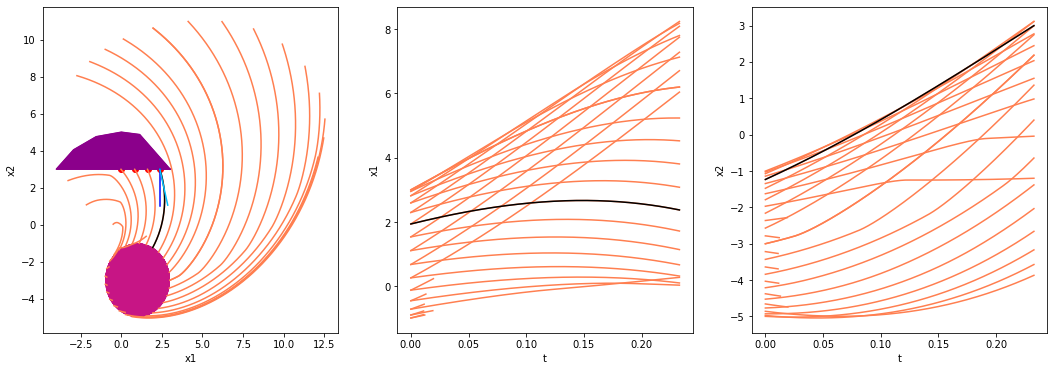

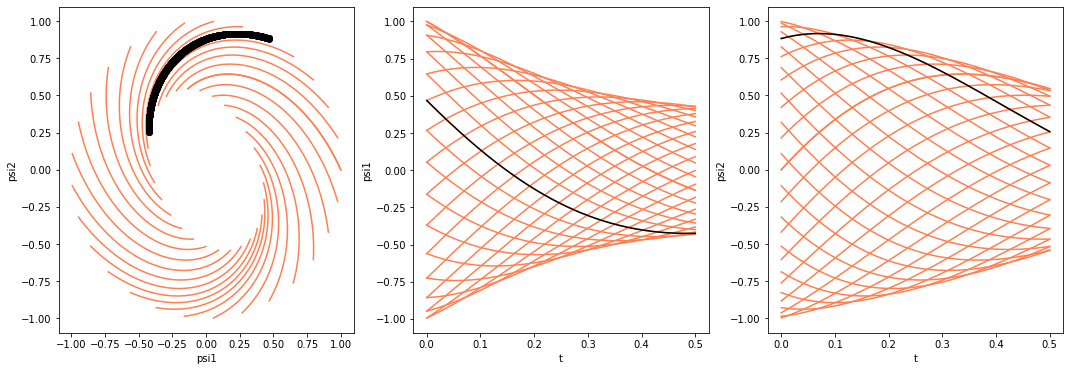

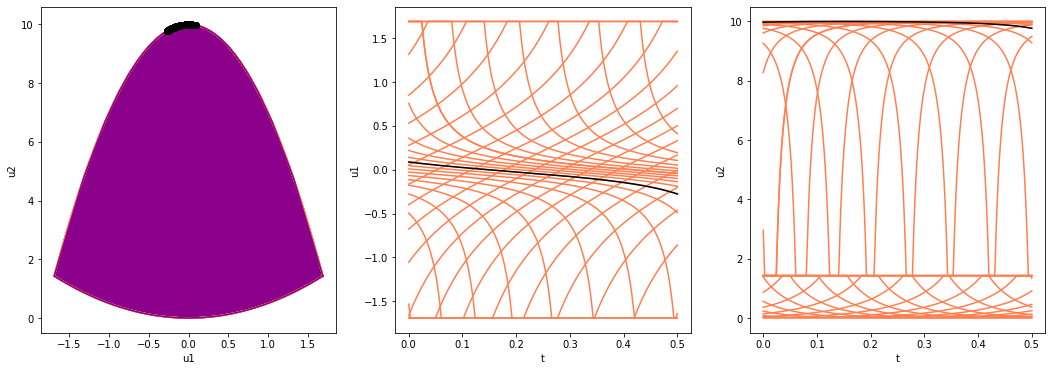

In [127]:
ls = LinearSolver(params)
ls.solve(30)

plot_all3(ls, ls.trajectory, ['x1', 'x2'])
plot_all3(ls, ls.psi_grid, ['psi1', 'psi2'])
u_grid = u(ls)
plot_all3(ls, u_grid, ['u1', 'u2'])

In [128]:
def A(t):
    return np.array([[0, -2],
                     [2, 0]])
def B(t):
    return np.eye(2)
#     return np.array([[2, -4],
#                      [3, 1]])

In [129]:
params1 = {
    'A': A,
    'B': B,
    't0': 0.,
    't1': 1,
    'a': 0.5,
    'b': 10.,
    'c': 3.,
    'r': 2.,
    'center': np.array([-5, -1]),
    'G': np.array([[1, 0],
                   [-1, 0],
                   [0, -1],
                   [0, 1]]),
    'g': np.array([-5, -1, 3, -5]), 
    'R': 10.,
    'n_grid_t':1000
}

C:\Users\Polina\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in long_scalars


t1_min = 0.9874067229078072
косинусная мера = 0.8617725446410597
t1_min = 0.9845471767165369
косинусная мера = 0.8576258033478166


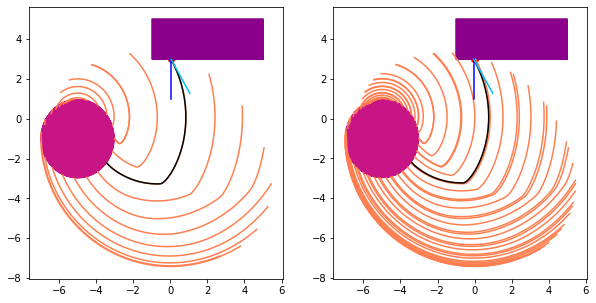

In [109]:
ls1 = LinearSolver(params1)
ls1.solve(20)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plot_ans(ls1, fig, ax1)
ls1.solve(40)
plot_ans(ls1, fig, ax2)

C:\Users\Polina\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in long_scalars


t1_min = 0.9874067229078072
[0.042939790981618514, 2.995770073877124]
косинусная мера = 0.9670625513171398
t1_min = 0.965498398502927
[-0.8023163701070913, 2.9955243441549384]
косинусная мера = 0.9888420443577899


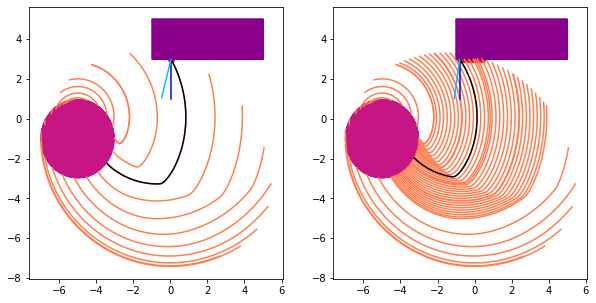

In [130]:
ls1 = LinearSolver(params1)
ls1.solve(20)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plot_ans(ls1, fig, ax1)
ls1.solve(30, local=True)
plot_ans(ls1, fig, ax2)

t1_min = 0.965498398502927
[-0.8023163701070913, 2.9955243441549384]
косинусная мера = 0.9888420443577899


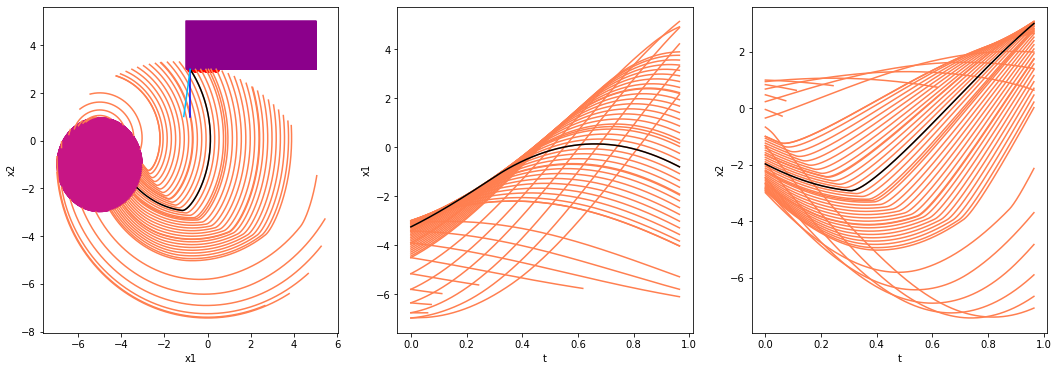

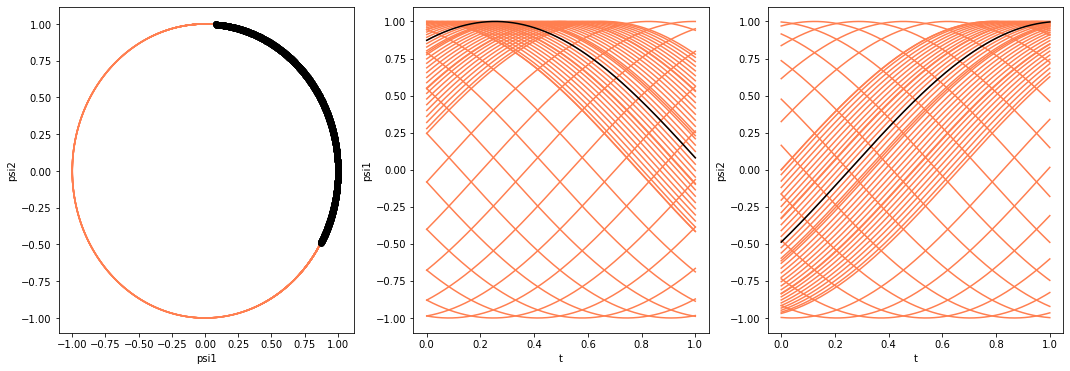

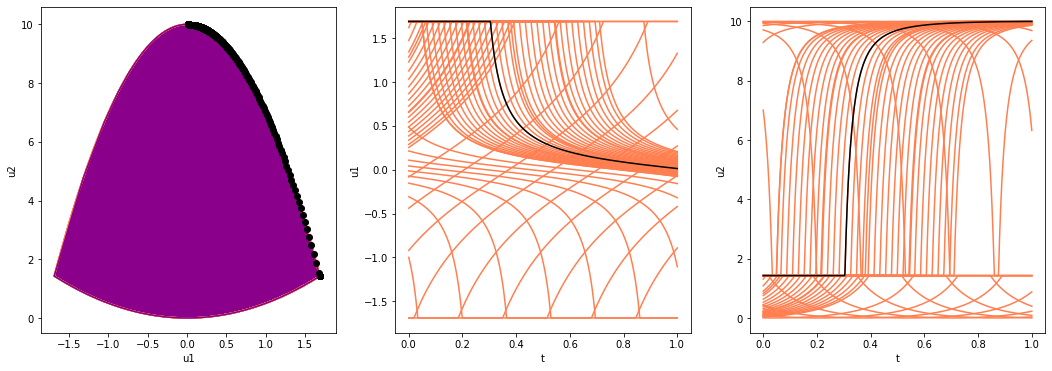

In [131]:
plot_all3(ls1, ls1.trajectory, ['x1', 'x2'])
plot_all3(ls1, ls1.psi_grid, ['psi1', 'psi2'])
u_grid = u(ls1)
plot_all3(ls1, u_grid, ['u1', 'u2'])

In [141]:
def A(t):
    return np.array([[1, 0],
                     [0, 3]])
def B(t):
    return np.array([[1, 1],
                     [2, 3]])

In [142]:
params1 = {
    'A': A,
    'B': B,
    't0': 0.,
    't1': 2,
    'a': 0.5,
    'b': 10.,
    'c': 3.,
    'r': 1.6,
    'center': np.array([3, 1]),
    'G': np.array([[1, 0],
                   [-1, 0],
                   [0, -1],
                   [0, 1]]),
    'g': np.array([-10, -3, -10, 5]), 
    'R': 30.,
    'n_grid_t':1000
}

C:\Users\Polina\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in long_scalars


t1_min = 0.6171927417870949
[5.015510240200202, -4.990982162285154]
косинусная мера = 0.983083625439556


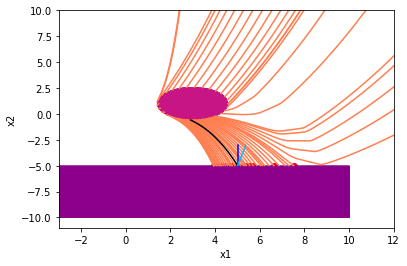

In [148]:
ls2 = LinearSolver(params1)
ls2.solve(30)
ls2.solve(30, local=True)
plot_ans(ls2)

t1_min = 0.6171956171119181
[5.342836049581258, -4.990937288079127]
косинусная мера = 0.9830834357872775


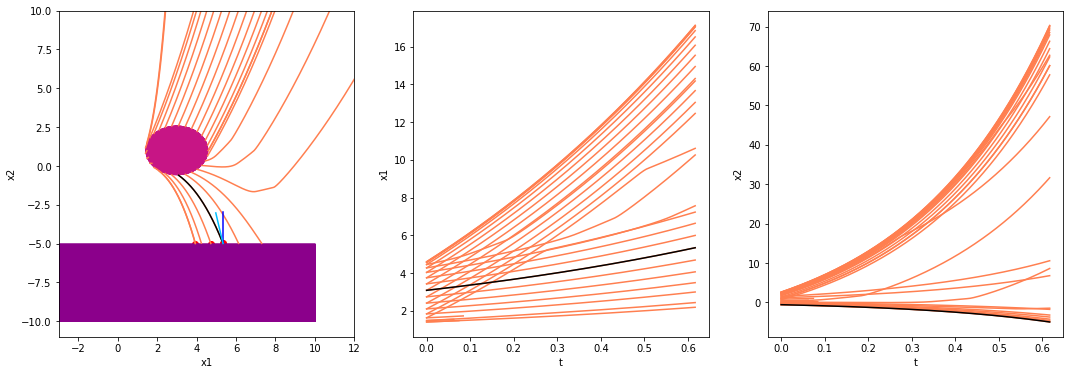

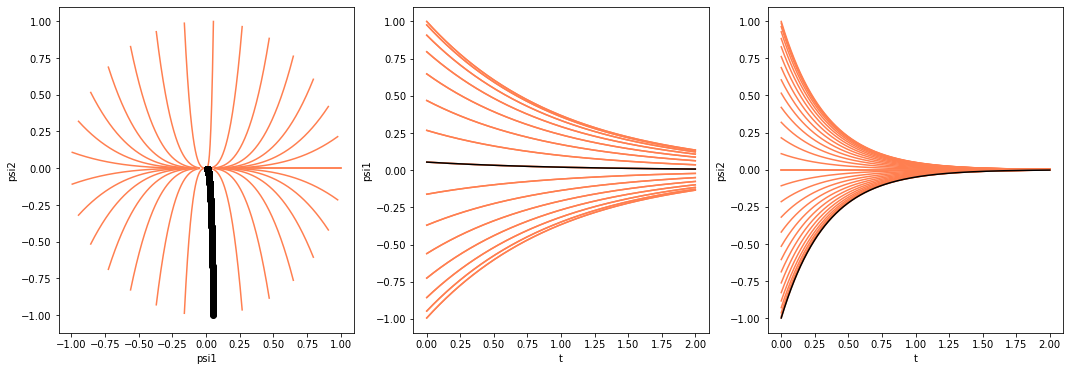

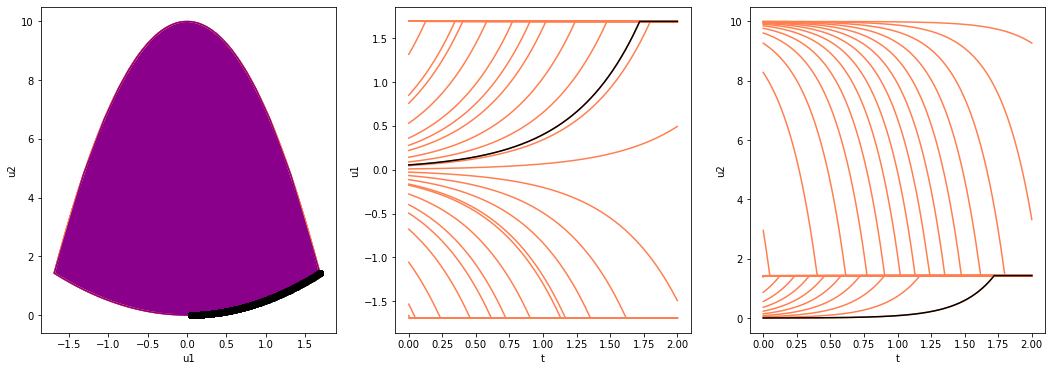

In [146]:
plot_all3(ls2, ls2.trajectory, ['x1', 'x2'])
plot_all3(ls2, ls2.psi_grid, ['psi1', 'psi2'])
u_grid = u(ls2)
plot_all3(ls2, u_grid, ['u1', 'u2'])

t1_min = 0.06609182446506529
косинусная мера = 0.9344323951971725


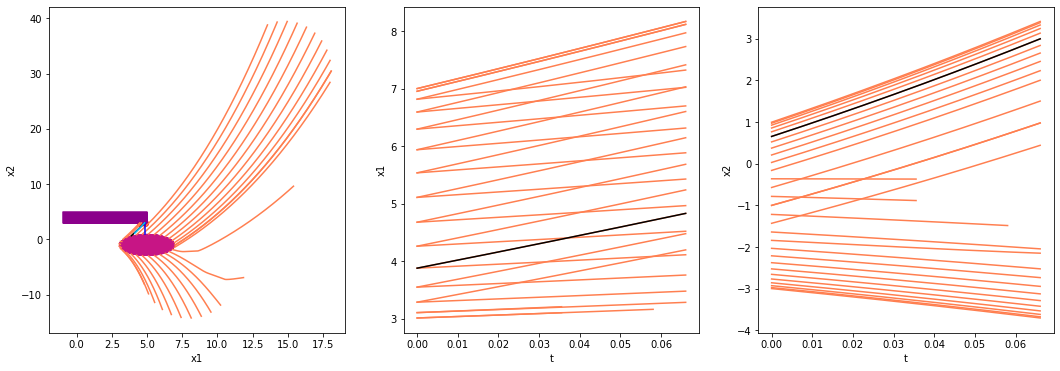

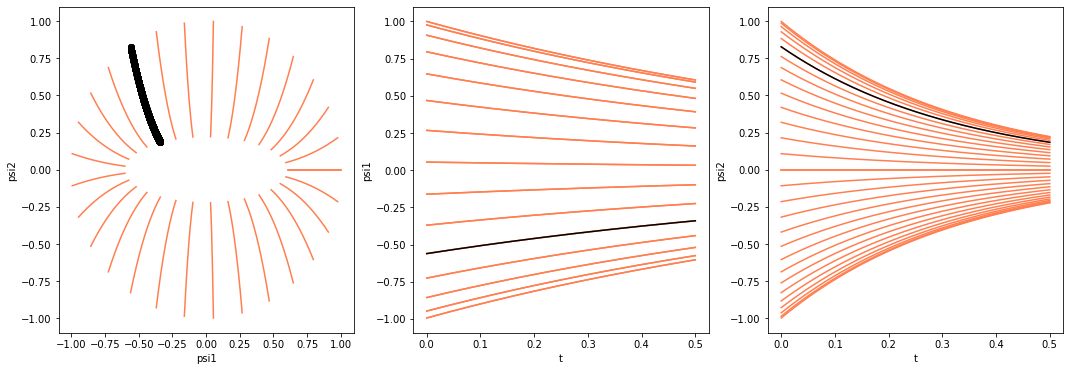

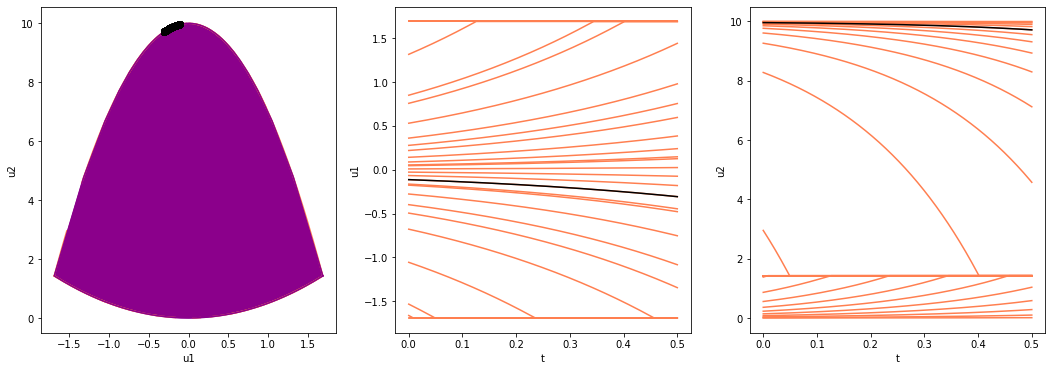

In [65]:
plot_all3(ls2, ls2.trajectory, ['x1', 'x2'])
plot_all3(ls2, ls2.psi_grid, ['psi1', 'psi2'])
u_grid = u(ls2)
plot_all3(ls2, u_grid, ['u1', 'u2'])

In [43]:
def A(t):
    return np.array([[cos(t), t],
                     [sin(t), sin(t)]])
def B(t):
    return np.array([[2 * sin(t), 3],
                     [-1, 1]])

In [58]:
params1 = {
    'A': A,
    'B': B,
    't0': 0.,
    't1': 1,
    'a': 0.5,
    'b': 10.,
    'c': 3.,
    'r': 1.6,
    'center': np.array([-10, 10]),
    'G': np.array([[1, 0],
                   [-1, 0],
                   [0, -1],
                   [0, 1]]),
    'g': np.array([-5, -6, 5, -15]), 
    'R': 30.,
    'n_grid_t':1000
}

C:\Users\Polina\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in long_scalars


t1_min = 0.1044411605783196
косинусная мера = 0.92227674037925


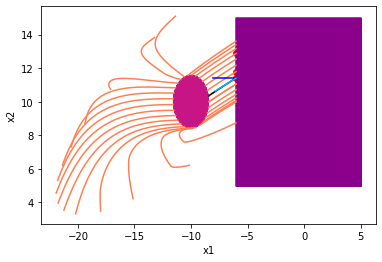

In [59]:
ls3 = LinearSolver(params1)
ls3.solve(30)
plot_ans(ls3)

t1_min = 0.1044411605783196
косинусная мера = 0.92227674037925


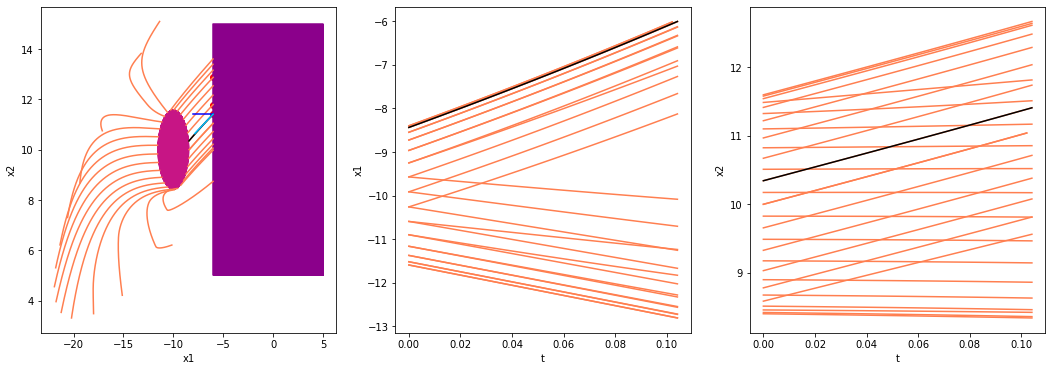

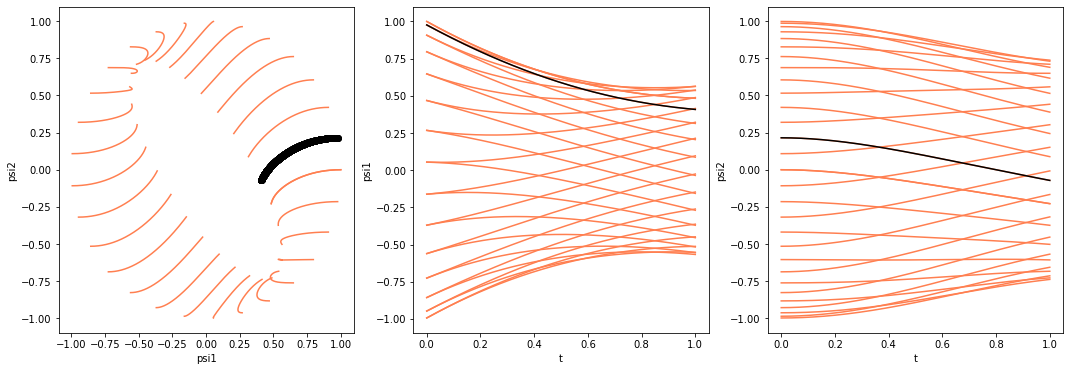

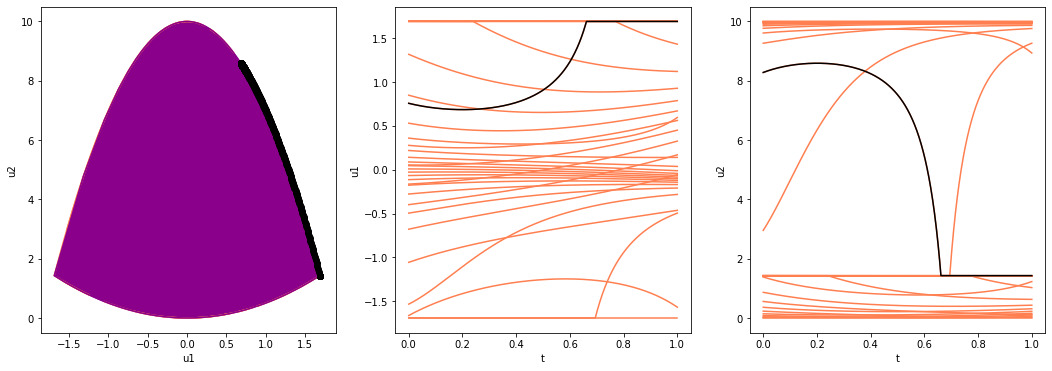

In [62]:
plot_all3(ls3, ls3.trajectory, ['x1', 'x2'])
plot_all3(ls3, ls3.psi_grid, ['psi1', 'psi2'])
u_grid = u(ls3)
plot_all3(ls3, u_grid, ['u1', 'u2'])

In [161]:
def A(t):
    return np.array([[0, 3],
                     [-3, 0]])
def B(t):
    return np.eye(2, 2)

In [164]:
params1 = {
    'A': A,
    'B': B,
    't0': 0.,
    't1': 3,
    'a': 0.5,
    'b': 10.,
    'c': 3.,
    'r': 1.6,
    'center': np.array([-2, -2.5]),
    'G': np.array([[1, 0],
                   [-1, 0],
                   [0, -1],
                   [0, 1]]),
#     'g': np.array([-15, 10, 3, -15]), 
    'g': np.array([-15, 10, 5, -15]),
    'R': 30.,
    'n_grid_t':1000
}

C:\Users\Polina\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in long_scalars


t1_min = 1.0633297639578385
[9.995863730107597, 5.069133195334729]
косинусная мера = 0.8807952262311947


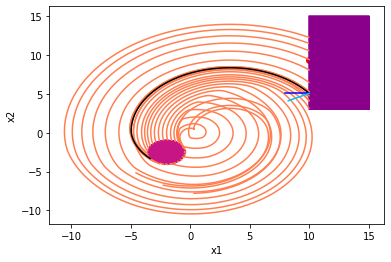

In [163]:
ls3 = LinearSolver(params1)
ls3.solve(30)
plot_ans(ls3)

C:\Users\Polina\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in long_scalars


t1_min = 2.6729937507995354
[9.990808680911718, 9.424691469191158]
косинусная мера = 0.9086237445595758


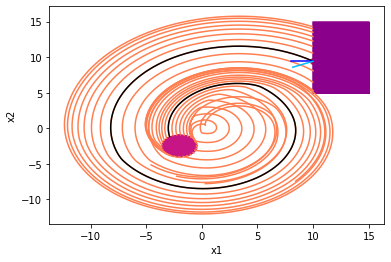

In [168]:
ls3 = LinearSolver(params1)
ls3.solve(30)
plot_ans(ls3)